<a href="https://www.kaggle.com/code/nadaarfaoui/doctor-s-prescription?scriptVersionId=288416534" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Doctor's Prescription — Notebook
This notebook delegates heavy preprocessing and model training to external scripts to keep kernels stable.

How to run on Kaggle: the notebook prefers a top-level `run_kaggle.py` (or the Kaggle utility path like `/kaggle/usr/lib/run_kaggle/run_kaggle.py`).

To run everything from this notebook: execute the code cell labeled "Launch full pipeline" — it invokes the orchestrator using the current Python executable and will run preprocess → train → convert.

Tip: keep heavy imports (transformers/tokenizers) in the consolidated imports cell and run it only when needed.

In [1]:
# Consolidated imports — run this cell first
# --- Standard library ---
import os
import json
import gc
import glob
import time
import sys
import subprocess
from pathlib import Path

# --- Data science ---
import pandas as pd
import numpy as np

# --- Imaging / visualization ---
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# --- OCR / utilities ---
import pytesseract
import joblib
import psutil

# --- ML frameworks ---
import tensorflow as tf
import torch

# --- Scikit-learn ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# --- Transformers / Tokenizers (heavy) ---
# These are included here to keep all imports in one place; run this cell only when needed
from transformers import (
    BertTokenizerFast,
    BertConfig,
    BertForMaskedLM,
    AdamW,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq,
)
from torch.utils.data import Dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer

# End of imports

In [2]:
# Setup constants and environment for Kaggle
# Default dataset root used in scripts/run_kaggle.py
DATASET_ROOT = '/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset'
PROCESSED_DIR = Path('data/processed')
WORK_DIR = Path('/kaggle/working')

# Scripts location detection (supports Kaggle utility paths and dataset inputs)
SCRIPTS_DIR = Path('scripts')
# If `scripts/` isn't present (common on Kaggle), prefer Kaggle utility layout under /kaggle/usr/lib
if not SCRIPTS_DIR.exists():
    # First, check for Kaggle utility scripts under /kaggle/usr/lib (e.g. /kaggle/usr/lib/train_cnn/train_cnn.py)
    kaggle_utils = glob.glob('/kaggle/usr/lib/**/run_kaggle.py', recursive=True) + glob.glob('/kaggle/usr/lib/**/train_cnn.py', recursive=True) + glob.glob('/kaggle/usr/lib/**/load_images.py', recursive=True)
    if kaggle_utils:
        SCRIPTS_DIR = Path(kaggle_utils[0]).parent
    else:
        # Look for a 'scripts' folder inside added Kaggle input datasets
        candidates = glob.glob('/kaggle/input/**/scripts', recursive=True)
        if candidates:
            SCRIPTS_DIR = Path(candidates[0])
        else:
            # Fallback: if our individual script files exist in a dataset, use that parent
            candidates2 = glob.glob('/kaggle/input/**/train_cnn.py', recursive=True)
            if candidates2:
                SCRIPTS_DIR = Path(candidates2[0]).parent
            else:
                # No scripts folder found — use repository root so Path('train_cnn.py') will be resolved
                SCRIPTS_DIR = Path('.')

print('DATASET_ROOT =', DATASET_ROOT)
print('PROCESSED_DIR =', PROCESSED_DIR)
print('WORK_DIR =', WORK_DIR)
print('SCRIPTS_DIR =', SCRIPTS_DIR)

DATASET_ROOT = /kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset
PROCESSED_DIR = data/processed
WORK_DIR = /kaggle/working
SCRIPTS_DIR = /kaggle/usr/lib/run_kaggle


In [3]:
# Helper: resolve script path from common locations (repo root, /kaggle/usr/lib/<name>/, SCRIPTS_DIR, /kaggle/input)**)
def resolve_script(script_name, prefer_usr_lib=True):
    """Return a Path to an existing script, preferring locations in this order:\n    1) repo root Path(script_name)\n    2) /kaggle/usr/lib/<stem>/<script_name> (if prefer_usr_lib)\n    3) SCRIPTS_DIR / script_name (if SCRIPTS_DIR exists)\n    4) any /kaggle/input/**/script_name match\    Raises FileNotFoundError if none found."""
    candidates = []
    # 1) repo root (project-local)
    candidates.append(Path(script_name))
    # 2) Kaggle utility layout: /kaggle/usr/lib/<stem>/<script_name>
    stem = Path(script_name).stem
    if prefer_usr_lib:
        candidates.append(Path(f'/kaggle/usr/lib/{stem}/{script_name}'))
    # 3) scripts dir discovered earlier
    try:
        if 'SCRIPTS_DIR' in globals() and SCRIPTS_DIR is not None:
            candidates.append(SCRIPTS_DIR / script_name)
    except Exception:
        pass
    # 4) search in /kaggle/input/**
    matches = glob.glob(f'/kaggle/input/**/{script_name}', recursive=True)
    for m in matches:
        candidates.append(Path(m))
    # Return first existing candidate
    for p in candidates:
        try:
            if p.exists():
                return p
        except Exception:
            continue
    raise FileNotFoundError(f'Script {script_name} not found in candidates: {candidates}')

# Quick check helper
def print_resolved(script_name):
    try:
        p = resolve_script(script_name)
        print(f'Resolved {script_name} ->', p)
    except FileNotFoundError as e:
        print(e)

In [4]:
# Load `history` and `test` produced by external scripts (early loader)
# This ensures these globals exist for static analyzers and later cells.
history = None
test = None

# Typical artifact locations
try:
    WORK_DIR = Path('/kaggle/working')
except Exception:
    WORK_DIR = Path('.')
PROCESSED_DIR = Path('data/processed')
# Try to load a saved training history (written by training scripts as *.history.json)
hist_candidates = []
if WORK_DIR.exists():
    hist_candidates = sorted(WORK_DIR.glob('*.history.json'))
if not hist_candidates:
    hist_candidates = sorted(Path('.').glob('*.history.json'))
if hist_candidates:
    try:
        with open(hist_candidates[0]) as f:
            hist_dict = json.load(f)
        class HistoryWrapper:
            def __init__(self, d):
                self.history = d
        history = HistoryWrapper(hist_dict)
        print('Loaded training history from', hist_candidates[0])
    except Exception as e:
        print('Failed to load history:', e)
# Also try a deterministic history path written by the training script (CI-friendly)
if history is None:
    try:
        alt_hist = Path('/kaggle/working/prescription_classification_history.json')
        if alt_hist.exists():
            with open(alt_hist) as f:
                hist_dict = json.load(f)
            class HistoryWrapper:
                def __init__(self, d):
                    self.history = d
            history = HistoryWrapper(hist_dict)
            print('Loaded deterministic training history from', alt_hist)
    except Exception as e:
        print('Failed to load deterministic history:', e)
# Try to load test samples saved by preprocessing (data/processed/test_samples.npz)
test_paths = [PROCESSED_DIR / 'test_samples.npz', WORK_DIR / 'test_samples.npz', PROCESSED_DIR / 'test_samples.npy', WORK_DIR / 'test_samples.npy']
for tp in test_paths:
    try:
        tp = Path(tp)
        if tp.exists():
            if tp.suffix == '.npz':
                loaded = np.load(tp)
                test = loaded.get('test')
            else:
                test = np.load(tp)
            print('Loaded test samples from', tp)
            break
    except Exception as e:
        print('Failed loading test samples from', tp, e)
if test is None:
    print('No test samples found; latency benchmarks will be skipped unless you provide `test` array.')

No test samples found; latency benchmarks will be skipped unless you provide `test` array.


In [5]:
# Launch full pipeline (preprocess -> train -> convert) — robust runner
print('Launching full pipeline via run_kaggle.py')
# Try resolving orchestrator via resolve_script and run it (capturing output)
try:
    script_path = resolve_script('run_kaggle.py')
    print('Using orchestrator:', script_path)
    try:
        result = subprocess.run([sys.executable, str(script_path)], capture_output=True, text=True, check=True)
        print('Orchestrator completed successfully:', script_path)
        if result.stdout:
            print('--- orchestrator stdout ---')
            print(result.stdout)
        if result.stderr:
            print('--- orchestrator stderr ---')
            print(result.stderr)
    except subprocess.CalledProcessError as e:
        print(f'Orchestrator {script_path} failed with returncode {e.returncode}')
        print('--- captured stdout ---')
        print(e.stdout if e.stdout else '<no stdout>')
        print('--- captured stderr ---')
        print(e.stderr if e.stderr else '<no stderr>')
        raise
except FileNotFoundError as e:
    print(e)
    raise

Launching full pipeline via run_kaggle.py
Using orchestrator: /kaggle/usr/lib/run_kaggle/run_kaggle.py
Orchestrator completed successfully: /kaggle/usr/lib/run_kaggle/run_kaggle.py
--- orchestrator stdout ---
Saved processed images and labels to data/processed
Found 3120 validated image filenames belonging to 78 classes.
Found 780 validated image filenames belonging to 78 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 82, 82, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 41, 41, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 39, 39, 32)        4640      
                                                                 
 m

In [6]:
# Load train/validation/test label CSVs
df_test = pd.read_csv('/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Testing/testing_labels.csv')
df_train = pd.read_csv('/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Training/training_labels.csv')
df_val = pd.read_csv('/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_labels.csv')

df_train.head()

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol


In [7]:
df_train

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol
...,...,...,...
3115,3115.png,Zithrin,Azithromycin Dihydrate
3116,3116.png,Zithrin,Azithromycin Dihydrate
3117,3117.png,Zithrin,Azithromycin Dihydrate
3118,3118.png,Zithrin,Azithromycin Dihydrate


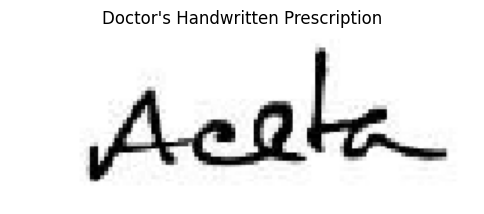

Image shape: (84, 227, 3)


In [8]:
# Display a sample image (RGB for Matplotlib)
image_path = '/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/1.png'
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Doctor's Handwritten Prescription")
plt.show()
print('Image shape:', img_rgb.shape)

In [9]:
# Run image preprocessing to produce disk-backed data
print('Running image preprocessing to create data/processed...')
script_name = 'load_images.py'
try:
    script_path = resolve_script(script_name)
    print('Using script:', script_path)
    subprocess.run([
        'python3', str(script_path),
        '--train-csv', '/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Training/training_labels.csv',
        '--train-dir', '/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Training/training_words',
        '--val-csv', '/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_labels.csv',
        '--val-dir', '/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_words',
        '--test-csv', '/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Testing/testing_labels.csv',
        '--test-dir', '/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Testing/testing_words',
        '--out-dir', 'data/processed',
    ], check=True)
except FileNotFoundError as e:
    print(e)

Running image preprocessing to create data/processed...
Using script: /kaggle/usr/lib/load_images/load_images.py
Saved processed images and labels to data/processed


In [10]:
df_test["MEDICINE_NAME"]

0        Aceta
1        Aceta
2        Aceta
3        Aceta
4        Aceta
        ...   
775    Zithrin
776    Zithrin
777    Zithrin
778    Zithrin
779    Zithrin
Name: MEDICINE_NAME, Length: 780, dtype: object

In [11]:
arr=df_train['MEDICINE_NAME'].unique()
map1={}

for pos,key in enumerate(arr):
    map1[key]=pos

df_train['MEDICINE_NAME']=df_train['MEDICINE_NAME'].map(map1)
df_test['MEDICINE_NAME']=df_test['MEDICINE_NAME'].map(map1)
df_val['MEDICINE_NAME']=df_val['MEDICINE_NAME'].map(map1)

df_test['MEDICINE_NAME']

0       0
1       0
2       0
3       0
4       0
       ..
775    77
776    77
777    77
778    77
779    77
Name: MEDICINE_NAME, Length: 780, dtype: int64

In [12]:
def create_model():
    model = tf.keras.models.Sequential([ 
          tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(84,84,3)),
          tf.keras.layers.MaxPooling2D(2,2),
          tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
          tf.keras.layers.MaxPooling2D(2,2),
          tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
          tf.keras.layers.MaxPooling2D(2,2),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dropout(0.4),
          tf.keras.layers.Dense(78, activation='softmax')
      ])

    model.compile(loss='sparse_categorical_crossentropy',
                    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                    metrics=['accuracy'])

    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 82, 82, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 41, 41, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 39, 39, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 19, 19, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)         0

In [13]:
# Prepare labels and launch external CNN training
y_train = np.array(df_train['MEDICINE_NAME'])
y_val = np.array(df_val['MEDICINE_NAME'])
y_test = np.array(df_test['MEDICINE_NAME'])

print('Launching CNN training script (external)')
script_name = 'train_cnn.py'
try:
    script_path = resolve_script(script_name)
    print('Using script:', script_path)
    subprocess.run([
        'python3', str(script_path),
        '--data-dir', 'data/processed',
        '--output', '/kaggle/working/prescription_classification_model.h5',
        '--epochs', '15',
        '--batch-size', '128',
    ], check=True)
except FileNotFoundError as e:
    print(e)

Launching CNN training script (external)
Using script: /kaggle/usr/lib/train_cnn/train_cnn.py
Found 3120 validated image filenames belonging to 78 classes.
Found 780 validated image filenames belonging to 78 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 82, 82, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 41, 41, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 39, 39, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 19, 19, 32)        0         
 g2D)                                                            
                                     

/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Loaded deterministic history from /kaggle/working/prescription_classification_history.json


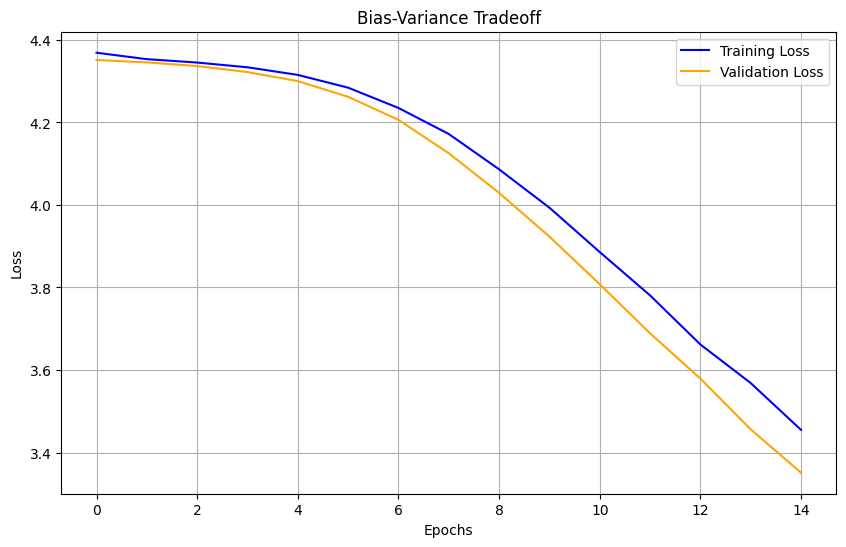

In [14]:
# Plot training/validation loss (if `history` is available)
# If training wrote a deterministic history file, load it here to ensure `history` is populated.
if 'history' not in globals() or history is None:
    try:
        alt = Path('/kaggle/working/prescription_classification_history.json')
        if alt.exists():
            with open(alt) as f:
                hist_dict = json.load(f)
            class HistoryWrapper:
                def __init__(self, d):
                    self.history = d
            history = HistoryWrapper(hist_dict)
            print('Loaded deterministic history from', alt)
    except Exception as e:
        print('Failed to load deterministic history:', e)

if 'history' in globals() and history is not None and hasattr(history, 'history'):
    try:
        plt.figure(figsize=(10, 6))
        plt.plot(history.history.get('loss', []), label='Training Loss', color='blue')
        plt.plot(history.history.get('val_loss', []), label='Validation Loss', color='orange')
        plt.title('Bias-Variance Tradeoff')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()
    except Exception as e:
        print('Failed to plot history:', e)
else:
    print('`history` not found — run training to populate training history.')

In [15]:
# Artifact locations
print('Training scripts save models to /kaggle/working by default.')
print('CNN:   ', '/kaggle/working/prescription_classification_model.h5')
print('LSTM:  ', '/kaggle/working/prescription_lstm.h5')
print('AlexNet:', '/kaggle/working/prescription_classification_alexnet.h5')

Training scripts save models to /kaggle/working by default.
CNN:    /kaggle/working/prescription_classification_model.h5
LSTM:   /kaggle/working/prescription_lstm.h5
AlexNet: /kaggle/working/prescription_classification_alexnet.h5


In [16]:
# Convert trained Keras model to TFLite using script
print('Converting Keras model to TFLite using script')
script_name = 'convert_tflite.py'
try:
    script_path = resolve_script(script_name)
    print('Using script:', script_path)
    subprocess.run([
        'python3', str(script_path),
        '--model', '/kaggle/working/prescription_classification_model.h5',
        '--output', '/kaggle/working/prescription_classification_quantized.tflite',
    ], check=True)
except FileNotFoundError as e:
    print(e)

Converting Keras model to TFLite using script
Using script: /kaggle/usr/lib/convert_tflite/convert_tflite.py


W0000 00:00:1766682986.691226     898 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1766682986.691297     898 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.


Saved TFLite to /kaggle/working/prescription_classification_quantized.tflite


In [17]:
# Run external LSTM training script
print('Running LSTM training script (external)...')
script_name = 'train_lstm.py'
try:
    script_path = resolve_script(script_name)
    print('Using script:', script_path)
    subprocess.run([
        'python3', str(script_path),
        '--data-dir', 'data/processed',
        '--output', '/kaggle/working/prescription_lstm.h5',
        '--epochs', '3',
        '--batch-size', '128',
        '--size', '84',
    ], check=True)
except FileNotFoundError as e:
    print(e)

Running LSTM training script (external)...
Using script: /kaggle/usr/lib/train_lstm/train_lstm.py
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 84, 32)            36480     
                                                                 
 dropout (Dropout)           (None, 84, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                        

/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# Run external AlexNet training script
print('Running AlexNet training script (external)')
script_name = 'train_alexnet.py'
try:
    script_path = resolve_script(script_name)
    print('Using script:', script_path)
    subprocess.run([
        'python3', str(script_path),
        '--data-dir', 'data/processed',
        '--output', '/kaggle/working/prescription_classification_alexnet.h5',
        '--epochs', '3',
        '--batch-size', '128',
        '--size', '84',
    ], check=True)
except FileNotFoundError as e:
    print(e)

Running AlexNet training script (external)
Using script: /kaggle/usr/lib/train_alexnet/train_alexnet.py
Found 3120 validated image filenames belonging to 78 classes.
Found 780 validated image filenames belonging to 78 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 21, 21, 16)        5824      
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 11, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                           

/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved AlexNet model to /kaggle/working/prescription_classification_alexnet.h5


In [19]:
# Performance Audit: Benchmarking Inference Latency (guarded)
tflite_path = Path('/kaggle/working/prescription_classification_quantized.tflite')
keras_path = Path('/kaggle/working/prescription_classification_model.h5')
interpreter = None
if tflite_path.exists():
    try:
        interpreter = tf.lite.Interpreter(model_path=str(tflite_path))
        interpreter.allocate_tensors()
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
    except Exception as e:
        print('Failed to create TFLite interpreter:', e)

# Try to load Keras model if available
keras_model = None
if keras_path.exists():
    try:
        keras_model = tf.keras.models.load_model(str(keras_path))
    except Exception as e:
        print('Failed to load Keras model:', e)

def measure_latency(model, input_data, iterations=50):
    """Measures average inference time (ms) for given model + input_data."""
    if model is None or input_data is None or len(input_data) == 0:
        raise ValueError('Model or input_data not available for latency measurement')
    total_time = 0.0
    n = min(iterations, len(input_data))
    for i in range(n):
        input_tensor = np.expand_dims(input_data[i], axis=0)
        start_time = time.time()
        if isinstance(model, tf.lite.Interpreter):
            # Ensure input tensor shape matches interpreter expectations
            try:
                model.set_tensor(input_details[0]['index'], input_tensor.astype(np.float32))
                model.invoke()
                _ = model.get_tensor(output_details[0]['index'])
            except Exception as e:
                raise
        else:
            model.predict(input_tensor, verbose=0)
        end_time = time.time()
        total_time += (end_time - start_time)
    return (total_time / n) * 1000

# Determine test data to use
test_data = None
if 'test' in globals() and test is not None and len(test) > 0:
    test_data = test
else:
    print('No `test` dataset found in the notebook globals; skipping latency benchmarks unless you provide `test` array.')

keras_latency = None
tflite_latency = None
if keras_model is not None and test_data is not None:
    try:
        keras_latency = measure_latency(keras_model, test_data)
    except Exception as e:
        print('Keras latency measurement failed:', e)
if interpreter is not None and test_data is not None:
    try:
        tflite_latency = measure_latency(interpreter, test_data)
    except Exception as e:
        print('TFLite latency measurement failed:', e)

print('--- Deployment Readiness Audit ---')
if keras_latency is not None:
    print(f'Original Keras CNN Latency: {keras_latency:.2f} ms per image')
else:
    print('Keras latency: not measured')
if tflite_latency is not None:
    print(f'Quantized TFLite CNN Latency: {tflite_latency:.2f} ms per image')
else:
    print('TFLite latency: not measured')
if keras_latency is not None and tflite_latency is not None and tflite_latency > 0:
    print(f'Speedup: {keras_latency / tflite_latency:.2f}x')
else:
    print('Speedup: unavailable')

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


No `test` dataset found in the notebook globals; skipping latency benchmarks unless you provide `test` array.
--- Deployment Readiness Audit ---
Keras latency: not measured
TFLite latency: not measured
Speedup: unavailable


In [20]:
# Compute model sizes and show a safe summary (guard against missing files/variables)
original_model = Path('/kaggle/working/prescription_classification_model.h5')
quantized_model = Path('/kaggle/working/prescription_classification_quantized.tflite')

if original_model.exists() and quantized_model.exists():
    original_size = original_model.stat().st_size
    quantized_size = quantized_model.stat().st_size
    reduction = 100 * (1 - (quantized_size / original_size)) if original_size > 0 else 0.0
    print('--- Optimization and Deployment Summary ---')
    print('Successfully optimized the primary CNN model using Post-Training Quantization.')
    print(f'Original size: {original_size / (1024**2):.2f} MB')
    print(f'Quantized size: {quantized_size / (1024**2):.2f} MB')
    print(f'Model Size Reduction: {reduction:.2f}%')
    try:
        print(f'Inference Speedup Achieved: {keras_latency / tflite_latency:.2f}x, making it suitable for edge deployment.')
    except Exception as e:
        print('Latency numbers unavailable:', e)
else:
    print('Model files not found; cannot compute size reduction.')
    if not original_model.exists():
        print('Missing original model:', original_model)
    if not quantized_model.exists():
        print('Missing quantized model:', quantized_model)

--- Optimization and Deployment Summary ---
Successfully optimized the primary CNN model using Post-Training Quantization.
Original size: 8.38 MB
Quantized size: 1.05 MB
Model Size Reduction: 87.47%
Latency numbers unavailable: unsupported operand type(s) for /: 'NoneType' and 'NoneType'


In [21]:
# Use OCR helpers from scripts/ocr_helper.py to avoid duplicating logic
try:
    from scripts.ocr_helper import preprocess_image, extract_text_with_ocr, XYocr as XYocr_helper
    def XYocr(folder):
        return XYocr_helper(folder, DATASET_ROOT)
    print('Using scripts.ocr_helper for OCR')
except Exception as e:
    print('Failed to import scripts.ocr_helper:', e)
    # Fallback: keep inline helpers if import fails (not recommended on Kaggle)
    def preprocess_image(image_path):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 32))
        _, img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return img
    def extract_text_with_ocr(image_path):
        preprocessed_image = preprocess_image(image_path)
        img = Image.fromarray(preprocessed_image)
        return pytesseract.image_to_string(img)
    def XYocr(folder):
        lower = folder.lower()
        csv_path = f'{DATASET_ROOT}/{folder}/{lower}_labels.csv'
        df = pd.read_csv(csv_path)
        Y = df['MEDICINE_NAME']
        image_folder = f'{DATASET_ROOT}/{folder}/{lower}_words/'
        image_paths = [os.path.join(image_folder, filename) for filename in df['IMAGE']]
        X = [extract_text_with_ocr(p) for p in image_paths]
        return X, Y

Failed to import scripts.ocr_helper: No module named 'scripts.ocr_helper'


In [22]:
# BERT training (requires running the heavy-imports cell first)
# Uses `scripts/ocr_helper.XYocr` via the XYocr() wrapper imported earlier
xTrain, yTrain = XYocr('Training')
xVal, yVal = XYocr('Validation')
xTest, yTest = XYocr('Testing')

# Define character-level vocabulary
vocab_list = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,!?')
vocab = {char: i for i, char in enumerate(vocab_list, start=1)}
vocab['[PAD]'] = 0
vocab['[MASK]'] = len(vocab) + 1
vocab['[CLS]'] = len(vocab) + 2
vocab['[SEP]'] = len(vocab) + 3
vocab['[UNK]'] = len(vocab) + 4

# Save vocab
vocab_file = 'vocab.txt'
with open(vocab_file, 'w') as f:
    for token in vocab:
        f.write(token + '\n')

# Initialize tokenizer and datasets (heavy)
tokenizer = BertTokenizerFast(vocab_file=vocab_file)
tokenizer.pad_token = '[PAD]'
tokenizer.mask_token = '[MASK]'
tokenizer.cls_token = '[CLS]'
tokenizer.sep_token = '[SEP]'
tokenizer.unk_token = '[UNK]'
tokenizer_output_dir = 'output_tokenizer'
os.makedirs(tokenizer_output_dir, exist_ok=True)
tokenizer.save_pretrained(tokenizer_output_dir)

class CustomDataset(Dataset):
    def __init__(self, x_data, y_data, tokenizer, max_length=128):
        self.x_data = x_data
        self.y_data = y_data
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.x_data)
    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        inputs = self.tokenizer(x, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        labels = self.tokenizer(y, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': labels['input_ids'].squeeze(),
        }

# Prepare datasets
train_dataset = CustomDataset(xTrain, yTrain, tokenizer)
val_dataset = CustomDataset(xVal, yVal, tokenizer)
test_dataset = CustomDataset(xTest, yTest, tokenizer)

# Build model config
config = BertConfig(vocab_size=len(vocab), hidden_size=256, num_hidden_layers=6, num_attention_heads=8, intermediate_size=512, max_position_embeddings=512)
model = BertForMaskedLM(config)
optimizer = AdamW(model.parameters(), lr=1e-4)
training_args = TrainingArguments(output_dir='output_model', num_train_epochs=3, per_device_train_batch_size=4, per_device_eval_batch_size=4, eval_strategy='epoch', save_strategy='epoch', logging_dir=None, logging_steps=1, report_to='none', save_steps=10, save_total_limit=1, load_best_model_at_end=True, disable_tqdm=False, fp16=False)

def compute_accuracy(p):
    preds, labels = p
    preds = torch.tensor(preds)
    preds = torch.argmax(preds, dim=-1)
    return {'accuracy': accuracy_score(labels.flatten(), preds.flatten())}

trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=val_dataset, optimizers=(optimizer, None), compute_metrics=compute_accuracy)
trainer.train()
final_metrics = trainer.evaluate(val_dataset)
test_metrics = trainer.evaluate(test_dataset)
print(f"Final Test Accuracy: {test_metrics.get('eval_accuracy')}")

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future 

Epoch,Training Loss,Validation Loss,Accuracy
1,0.013700,0.005625,0.999099
2,0.031200,0.004746,0.999099
3,0.001300,0.004607,0.999099


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


Final Test Accuracy: 0.9990985576923077
